In [ ]:
# ! pip install pandas matplotlib seaborn scikit-learn kagglehub numpy xgboost lightgbm catboost

In [5]:
# ! python.exe -m pip install --upgrade pip

# 1. Импорт библиотек и настройка визуализаций

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings

warnings.filterwarnings('ignore')

# Настройка визуализаций

plt.style.use('ggplot')
sns.set_palette("Set2")
%matplotlib inline

# 2. Загрузка данных

## Данные загружаются напрямую из kagglehub, что обеспечивает воспроизводимость. Загрузка датасета с помощью Kaggle API

In [7]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
file_path = f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

print("\nРазмер датасета:", df.shape)
print("\nПервые 5 строк:")
display(df.head())

print("\nИнформация о данных:")
df.info()

print("\nСтатистика числовых признаков:")
display(df.describe())


Размер датасета: (7043, 21)

Первые 5 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  70

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
print("Папка с датасетом:", path)
print("CSV-файл:", file_path)


Папка с датасетом: C:\Users\dogot\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1
CSV-файл: C:\Users\dogot\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [9]:
# Осмотр данных: Проведен первичный анализ: проверка размера датасета, типов данных (.info()) и основных статистических показателей (.describe()).
# Это позволило выявить, что столбец TotalCharges имеет некорректный тип данных (object).

# 3. Исследовательский анализ данных (EDA)

In [10]:
# Преобразование TotalCharges в числовой формат.
# Пробелы будут заменены на NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [11]:
display(df['TotalCharges'].isnull().sum())

np.int64(11)

In [12]:
# Фильтруем строки с пропущенными TotalCharges
missing_total_charges = df[df['TotalCharges'].isnull()]

# Выводим сами строки
display(missing_total_charges)

# Сколько таких строк
print("Количество строк с пропущенными TotalCharges:", missing_total_charges.shape[0])

# Индексы этих строк
print("Индексы строк с пропусками:", missing_total_charges.index.tolist())


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Количество строк с пропущенными TotalCharges: 11
Индексы строк с пропусками: [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]


In [13]:
# Заполняю пропущенные значения (возникшие из-за пустых строк) медианой
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [14]:
# Очистка: Проблема с TotalCharges решена путём преобразования в числовой тип и заполнения пропусков медианным значением.

## 3.1 Визуализация

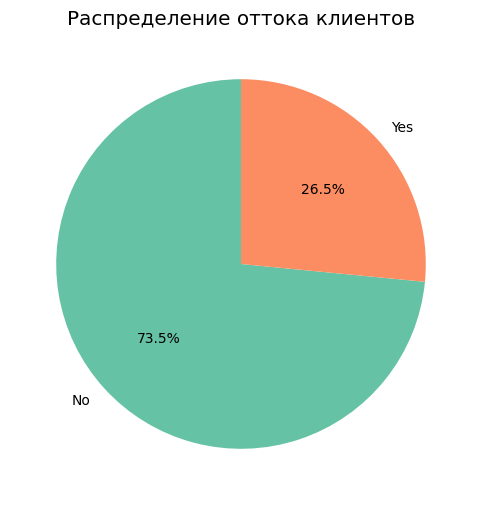

In [15]:
# Анализ целевой переменной
plt.figure(figsize=(6, 6))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение оттока клиентов')
plt.show()

In [16]:
# Построена круговая диаграмма для оценки баланса классов целевой переменной (Churn), которая показала дисбаланс (отток составляет ~26.5%).

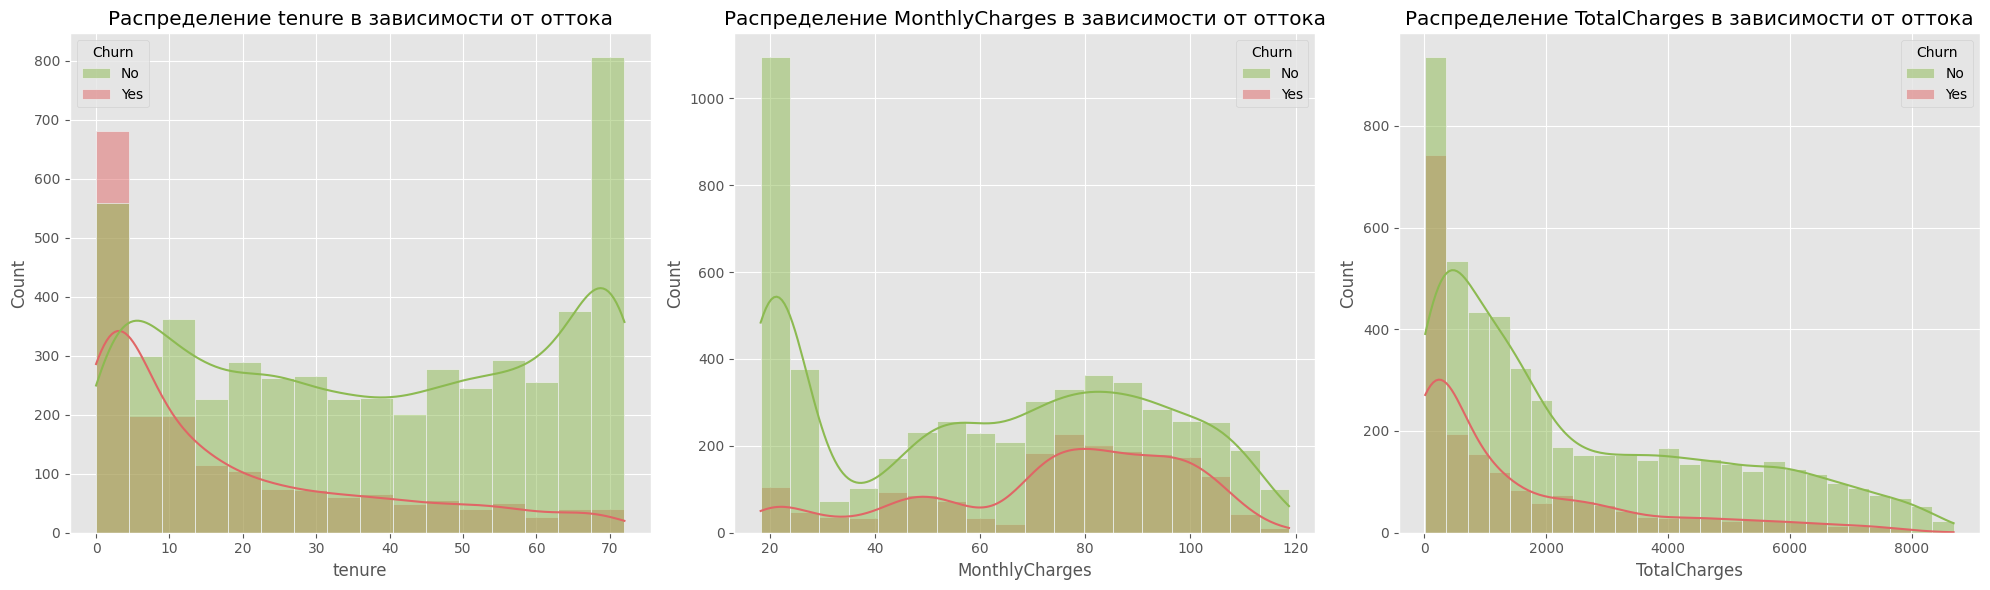

In [17]:
# Анализ числовых признаков
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, col in enumerate(numeric_cols):
    sns.histplot(df, x=col, hue='Churn', kde=True, ax=axes[i], palette=['#8cba51', '#e06666'])
    axes[i].set_title(f'Распределение {col} в зависимости от оттока')
plt.tight_layout()
plt.show()

In [18]:
# Гистограммы числовых признаков (tenure, MonthlyCharges, TotalCharges) в разрезе оттока наглядно показали их влияние на целевую переменную.

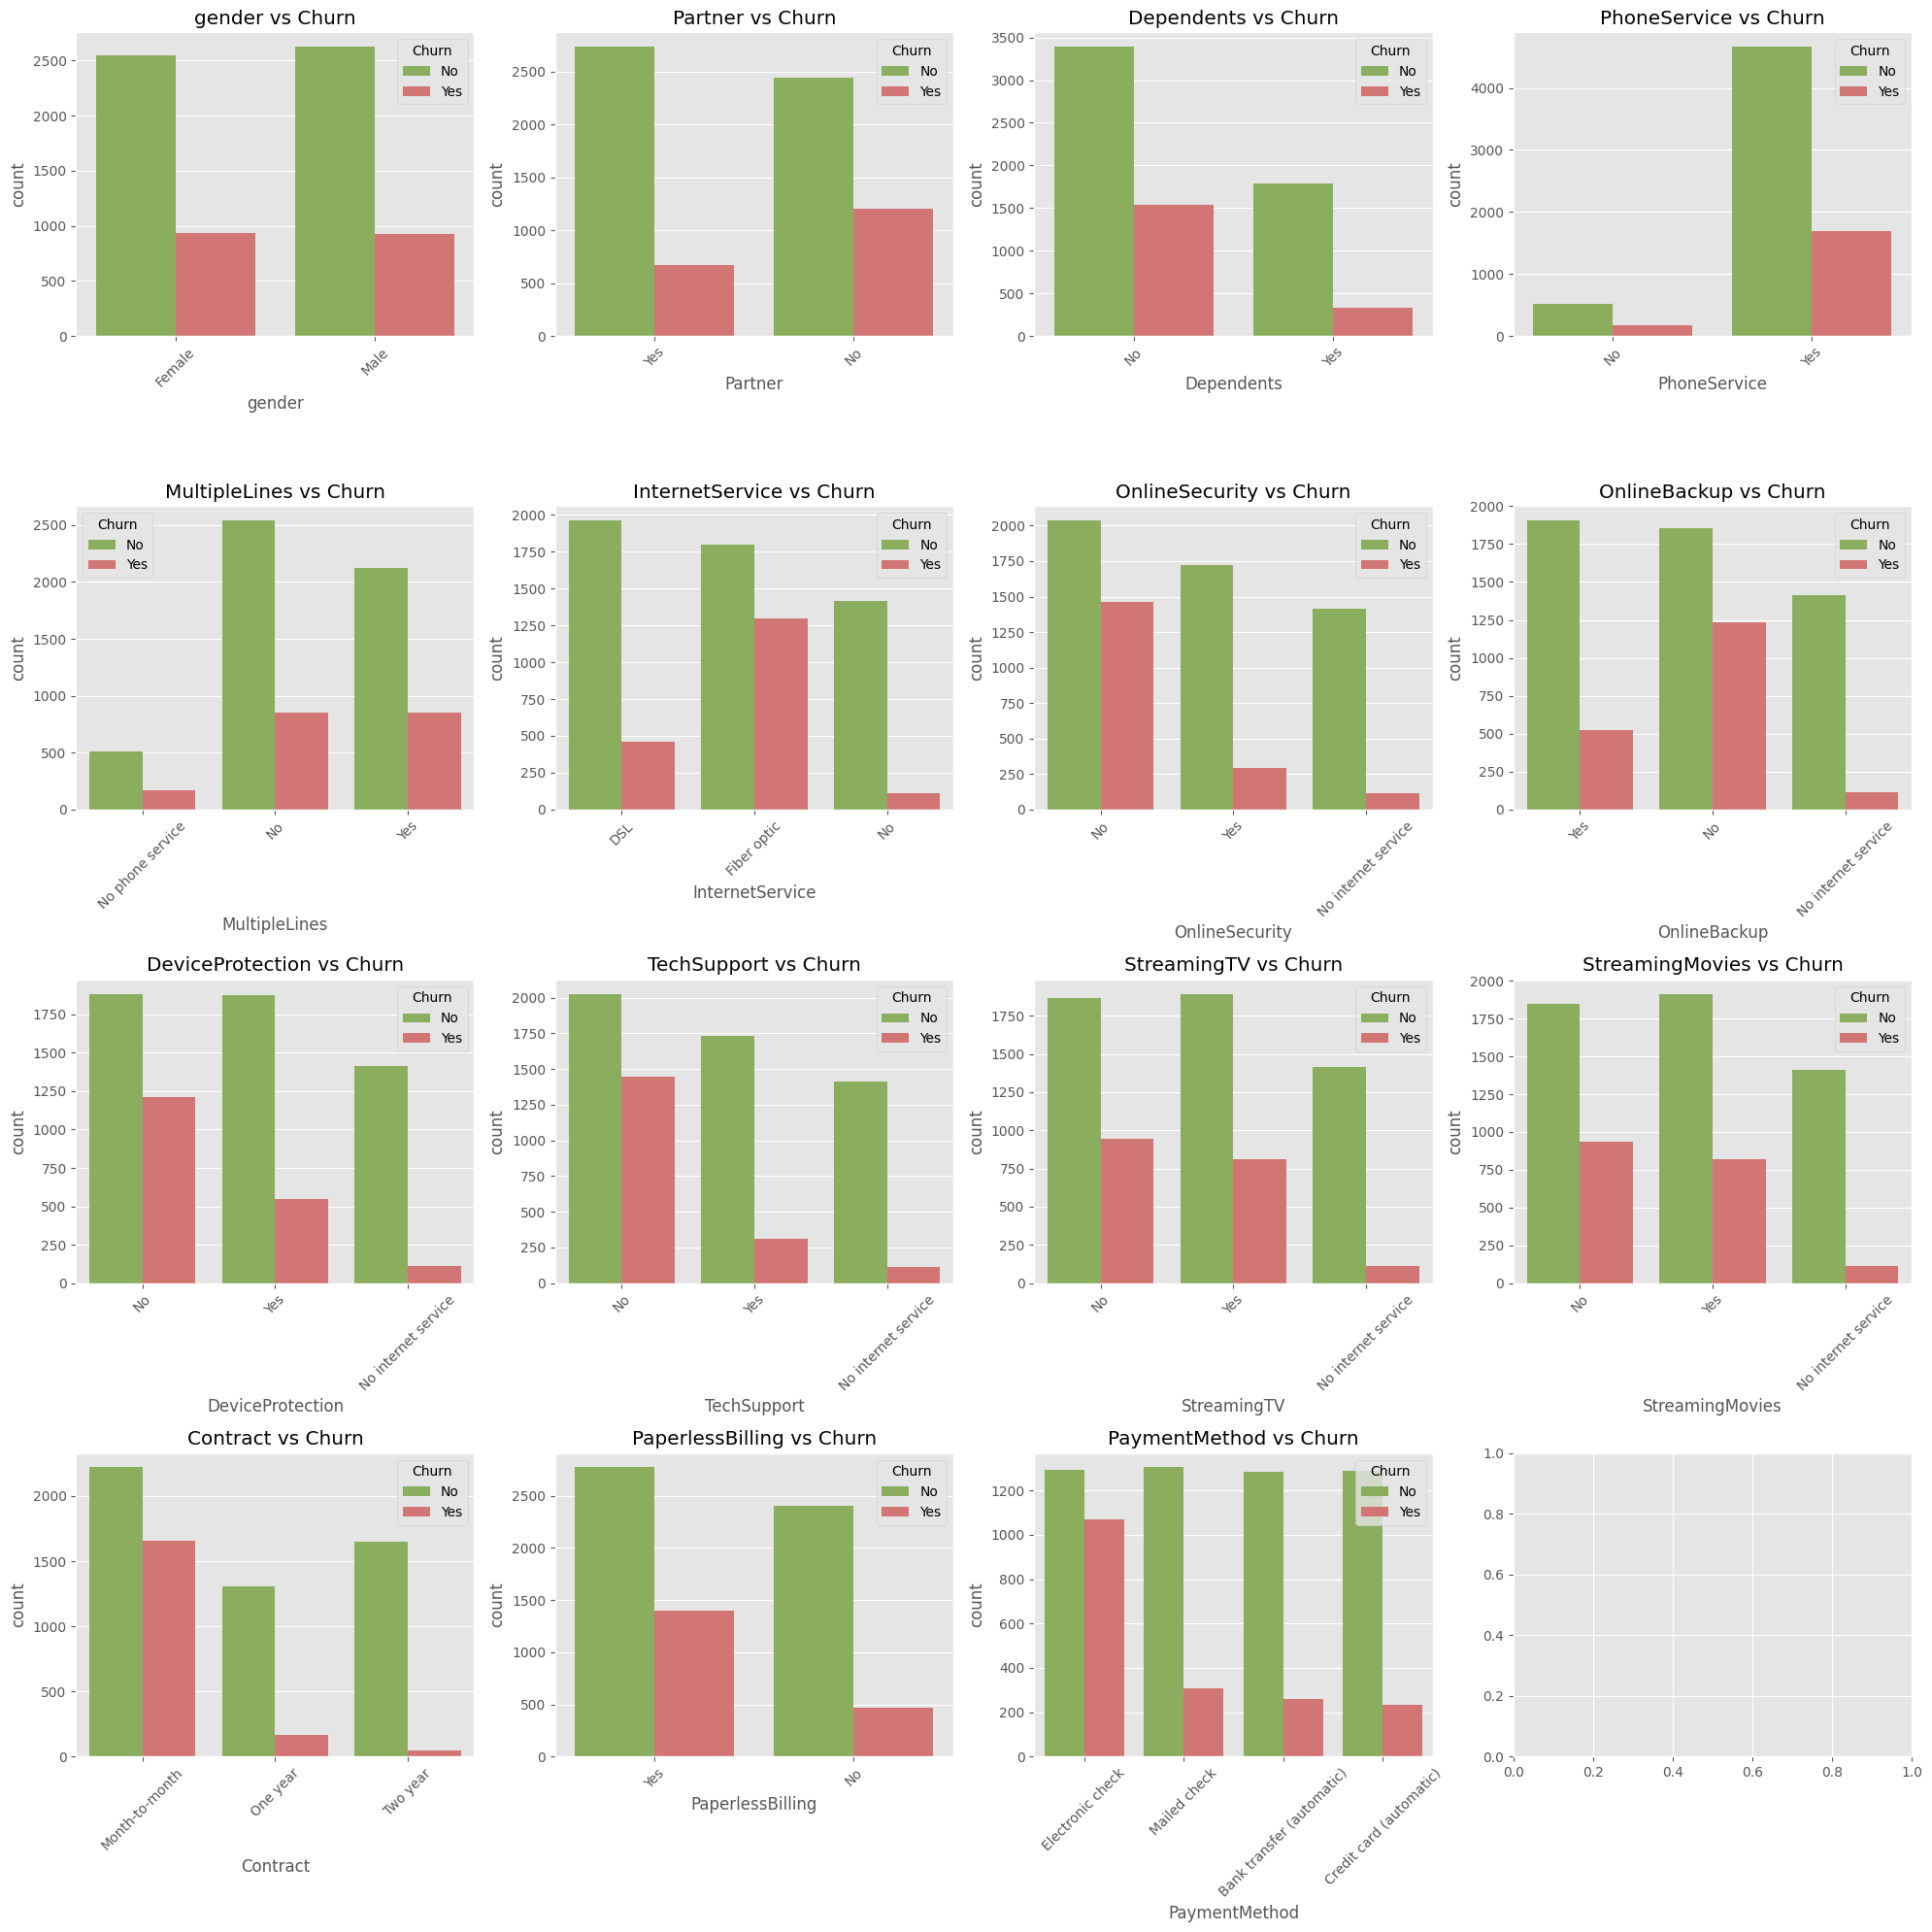

In [19]:
# Анализ категориальных признаков
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if col != 'Churn':
        sns.countplot(x=col, hue='Churn', data=df, ax=axes[i], palette=['#8cba51', '#e06666'])
        axes[i].set_title(f'{col} vs Churn')
        axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Столбчатые диаграммы для категориальных признаков позволили выявить ключевые факторы, влияющие на отток (например, тип контракта, наличие техподдержки).

In [21]:
# ! pip freeze > requirements.txt

# 4. Подготовка данных

In [22]:
# Удаляю неинформативный столбец customerID.
df.drop(['customerID'], axis=1, inplace=True)

In [23]:
# Категориальные признаки кодирую: бинарные — с помощью LabelEncoder, а мультиклассовые — через One-Hot Encoding (get_dummies).
# Кодирую бинарные признаки
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Кодирую целевую переменную
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# One-Hot Encoding для остальных категориальных признаков
multi_category_cols = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=multi_category_cols, drop_first=True)

print("\nРазмер датасета после обработки признаков:", df.shape)



Размер датасета после обработки признаков: (7043, 31)


In [24]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   int64  
 1   SeniorCitizen                          7043 non-null   int64  
 2   Partner                                7043 non-null   int64  
 3   Dependents                             7043 non-null   int64  
 4   tenure                                 7043 non-null   int64  
 5   PhoneService                           7043 non-null   int64  
 6   PaperlessBilling                       7043 non-null   int64  
 7   MonthlyCharges                         7043 non-null   float64
 8   TotalCharges                           7043 non-null   float64
 9   Churn                                  7043 non-null   int64  
 10  MultipleLines_No phone service         7043 non-null   bool   
 11  Mult

None

In [25]:
# Разделение и масштабирование:
# Данные разделяю на обучающую (80%) и тестовую (20%) выборки со стратификацией (stratify=y), что критически важно при дисбалансе классов.


# Разделение на признаки (X) и целевую переменную (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Разделение на обучающую и тестовую выборки (СТРОГО ДО МАСТШТАБИРОВАНИЯ И ОТБОРА)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# Масштабирование числовых признаков
# Числовые признаки масштабирую с помощью StandardScaler после разделения выборки.
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nРазмеры выборок:")
print(f"Обучающая: {X_train.shape}, Тестовая: {X_test.shape}")


Размеры выборок:
Обучающая: (5634, 30), Тестовая: (1409, 30)


# 5. Отбор признаков

In [32]:
# С помощью метода SelectKBest (на основе F-статистики ANOVA) выбрал 20 наиболее значимых признаков для обучения моделей, это позволило снизить размерность и убрать "шум".
# Отбор 20 лучших признаков с помощью ANOVA F-test
# Обучаю селектор ТОЛЬКО на обучающих данных
selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [37]:
# Создаю DataFrame со всеми признаками
all_features_df = pd.DataFrame({
    'Признак': X_train.columns,
    'F-статистика': selector.scores_,
    'Отобран': selector.get_support()
}).sort_values('F-статистика', ascending=False)

print("Все признаки, отсортированные по значимости:")
print(all_features_df.head(30))  # Показываю топ-30

Все признаки, отсортированные по значимости:
                                  Признак  F-статистика  Отобран
4                                  tenure    763.890183     True
11            InternetService_Fiber optic    610.199922     True
28         PaymentMethod_Electronic check    595.424491     True
26                      Contract_Two year    566.070664     True
12                     InternetService_No    311.490238     True
13     OnlineSecurity_No internet service    311.490238     True
17   DeviceProtection_No internet service    311.490238     True
19        TechSupport_No internet service    311.490238     True
23    StreamingMovies_No internet service    311.490238     True
21        StreamingTV_No internet service    311.490238     True
15       OnlineBackup_No internet service    311.490238     True
7                          MonthlyCharges    229.903823     True
6                        PaperlessBilling    229.761099     True
8                            TotalCharges    

In [38]:
print("\nТолько отобранные признаки:")
print(all_features_df[all_features_df['Отобран'] == True])


Только отобранные признаки:
                                 Признак  F-статистика  Отобран
4                                 tenure    763.890183     True
11           InternetService_Fiber optic    610.199922     True
28        PaymentMethod_Electronic check    595.424491     True
26                     Contract_Two year    566.070664     True
12                    InternetService_No    311.490238     True
13    OnlineSecurity_No internet service    311.490238     True
17  DeviceProtection_No internet service    311.490238     True
19       TechSupport_No internet service    311.490238     True
23   StreamingMovies_No internet service    311.490238     True
21       StreamingTV_No internet service    311.490238     True
15      OnlineBackup_No internet service    311.490238     True
7                         MonthlyCharges    229.903823     True
6                       PaperlessBilling    229.761099     True
8                           TotalCharges    221.207653     True
25         

# 6. Обучение и оценка моделей

In [42]:
# Построение, оценка и оптимизация моделей. Обучение моделей: Было обучено и оценено 6 различных моделей классификации:
# Logistic Regression
# Decision Tree
# Random Forest
# Gradient Boosting
# XGBoost
# LightGBM
# CatBoost
# Оценка качества: Для каждой модели был рассчитан полный набор метрик (Accuracy, Precision, Recall, F1 Score, ROC AUC),
# построены матрицы ошибок и ROC-кривые. Это позволило провести всестороннее сравнение моделей.



models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": cb.CatBoostClassifier(random_state=42, verbose=0)
}

results = []
roc_curves = {}

# Функция для обучения и оценки модели
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"--- Обучение модели: {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Расчет метрик
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")
    print("Матрица ошибок:")
    print(confusion_matrix(y_test, y_pred))
    print("\nОтчет по классификации:")
    print(classification_report(y_test, y_pred))

    # Сохранение результатов
    results.append([name, accuracy, precision, recall, f1, roc_auc])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_curves[name] = (fpr, tpr, roc_auc)

# Оценка всех моделей
for name, model in models.items():
    evaluate_model(name, model, X_train_selected, y_train, X_test_selected, y_test)

--- Обучение модели: Logistic Regression ---
Accuracy: 0.7991
Precision: 0.6454
Recall: 0.5401
F1 Score: 0.5881
ROC AUC: 0.8399

Матрица ошибок:
[[924 111]
 [172 202]]

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

--- Обучение модели: Decision Tree ---
Accuracy: 0.7239
Precision: 0.4809
Recall: 0.5053
F1 Score: 0.4928
ROC AUC: 0.6534

Матрица ошибок:
[[831 204]
 [185 189]]

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1035
           1       0.48      0.51      0.49       374

    accuracy                           0.72      1409
   macro avg       0.65      0.65      0.65      1409
weighted avg       0.

# 7. Настройка гиперпараметров для RandomForest

In [ ]:
# Оптимизация: Для модели RandomForestClassifier настроил гиперпараметры с помощью GridSearchCV.

print("\n--- Настройка гиперпараметров для RandomForest ---")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
# Запуск поиска
grid_search.fit(X_train_selected, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_


--- Настройка гиперпараметров для RandomForest ---
Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# Оценка лучшей модели RandomForest
evaluate_model("Random Forest (Tuned)", best_rf, X_train_selected, y_train, X_test_selected, y_test)

--- Обучение модели: Random Forest (Tuned) ---
Accuracy: 0.8034
Precision: 0.6601
Recall: 0.5348
F1 Score: 0.5908
ROC AUC: 0.8423

Матрица ошибок:
[[932 103]
 [174 200]]

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [ ]:
# Оптимизированная модель показала наилучший результат по метрике ROC AUC (0.8423).

# 8. Сводка и визуализация результатов

In [ ]:
# Создал итоговую таблицы с результатами
# Результаты всех моделей сведены в итоговую таблицу и отсортированы по ROC AUC.


results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
results_df = results_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)

print("\n--- Итоговая таблица результатов ---")
display(results_df.round(4))


--- Итоговая таблица результатов ---


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest (Tuned),0.8034,0.6601,0.5348,0.5908,0.8423
1,Gradient Boosting,0.8006,0.6566,0.5214,0.5812,0.8417
2,Logistic Regression,0.7991,0.6454,0.5401,0.5881,0.8399
3,LightGBM,0.7991,0.6435,0.5455,0.5904,0.8342
4,XGBoost,0.7857,0.6118,0.5267,0.5661,0.8212
5,Random Forest,0.7871,0.6259,0.4920,0.5509,0.8149
6,Decision Tree,0.7239,0.4809,0.5053,0.4928,0.6534


In [ ]:
# Лучшей моделью по совокупности метрик стала Random Forest с настроенными гиперпараметрами, показав хороший баланс между точностью и полнотой. За ней с небольшим отрывом следует Gradient Boosting.

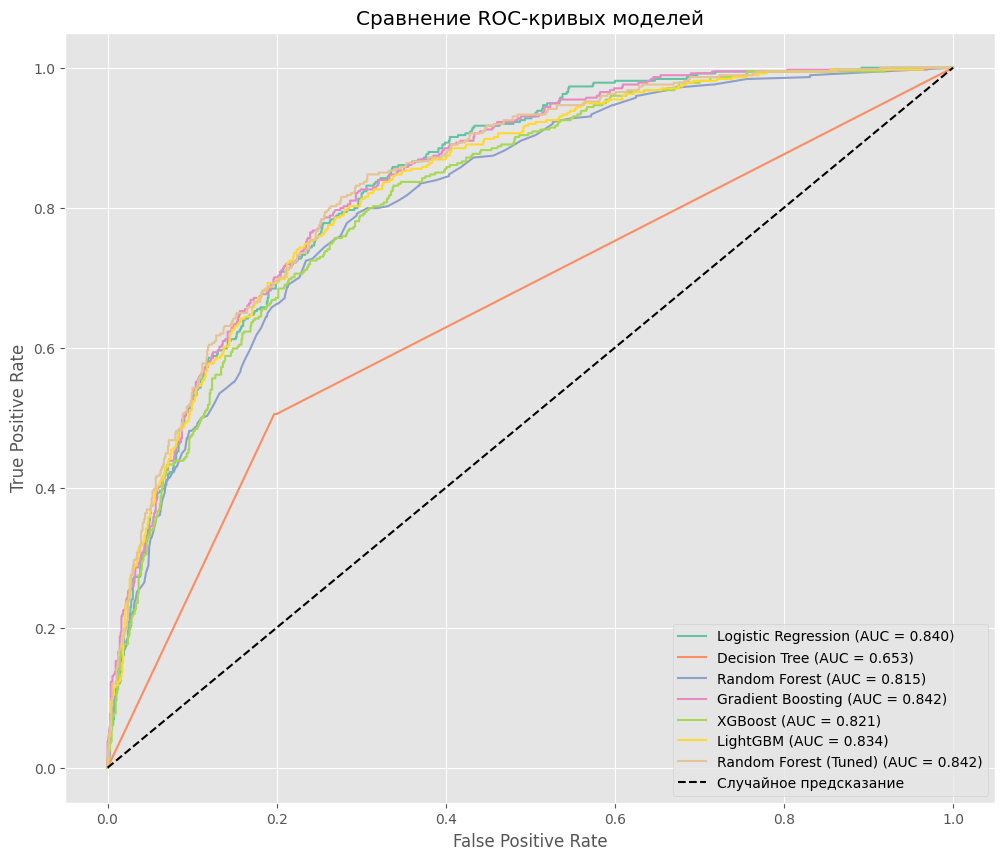

In [ ]:
# Визуализация ROC-кривых
plt.figure(figsize=(12, 10))
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайное предсказание')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых моделей')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Визуализация ROC-кривых наглядно подтвердила превосходство моделей ансамблевого типа над более простыми, такими как Decision Tree.

# 9. Создаем рекомендации по удержанию

In [ ]:
# Получаем прогнозы лучшей модели на тестовых данных
y_pred_best = best_rf.predict(X_test_selected)

In [ ]:
# Создаю DataFrame с фактическими и предсказанными значениями
results_analysis = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred_best
}, index=y_test.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   int64  
 1   SeniorCitizen                          7043 non-null   int64  
 2   Partner                                7043 non-null   int64  
 3   Dependents                             7043 non-null   int64  
 4   tenure                                 7043 non-null   int64  
 5   PhoneService                           7043 non-null   int64  
 6   PaperlessBilling                       7043 non-null   int64  
 7   MonthlyCharges                         7043 non-null   float64
 8   TotalCharges                           7043 non-null   float64
 9   Churn                                  7043 non-null   int64  
 10  MultipleLines_No phone service         7043 non-null   bool   
 11  Mult

In [ ]:
# Добавляю реальные месячные платежи (до масштабирования)
# Используем .loc для безопасного соединения по индексам
original_test_data = df.loc[y_test.index]
results_analysis['MonthlyCharges'] = original_test_data['MonthlyCharges']

In [ ]:
results_analysis

,y_test,y_pred,MonthlyCharges
437,0,0,114.05
2280,0,1,100.15
2235,0,0,78.35
4460,0,0,78.20
3761,0,0,82.65
...,...,...,...
5143,0,0,87.20
4439,0,0,20.30
3857,0,0,20.65
4758,0,0,19.70


In [ ]:
# 1. Определяею целевую аудиторию для удержания
# Это клиенты, для которых модель предсказала отток (y_pred == 1)
target_customers = results_analysis[results_analysis['y_pred'] == 1]

In [ ]:
# 2. Определяю допущения
LIFETIME_MONTHS = 12
COST_OF_RETENTION_COEF = 2  # Стоимость удержания = 2 * MonthlyCharges
SUCCESS_RATE = 0.40         # 40% клиентов примут предложение

In [ ]:
# 3. Расчеты
num_targeted = len(target_customers)
num_retained = int(num_targeted * SUCCESS_RATE)

In [ ]:
# Средний месячный платеж в целевой группе
avg_monthly_charge_targeted = target_customers['MonthlyCharges'].mean()

In [ ]:
# Общий доход от удержанных клиентов за год
total_revenue_from_retained = num_retained * avg_monthly_charge_targeted * LIFETIME_MONTHS

In [ ]:
# Общие затраты на кампанию удержания
total_cost_of_retention = num_targeted * avg_monthly_charge_targeted * COST_OF_RETENTION_COEF

In [ ]:
# Чистая экономическая выгода
net_profit = total_revenue_from_retained - total_cost_of_retention

In [ ]:
# ROI (Return on Investment)
roi = (net_profit / total_cost_of_retention) * 100

In [ ]:
# --- Подсчет целесообразности рекомендаций ---
print("--- Экономический анализ кампании по удержанию ---")
print(f"\nИсходные допущения:")
print(f"  - Срок жизни удержанного клиента: {LIFETIME_MONTHS} мес.")
print(f"  - Стоимость удержания: {COST_OF_RETENTION_COEF} месячных платежа")
print(f"  - Коэффициент конверсии предложения: {SUCCESS_RATE:.0%}")

print(f"\nРезультаты на тестовой выборке ({len(X_test)} клиентов):")
print(f"  - Клиентов, спрогнозированных на отток (целевая аудитория): {num_targeted}")
print(f"  - Средний месячный платеж в целевой группе: {avg_monthly_charge_targeted:.2f} $")
print(f"  - Ожидаемое количество удержанных клиентов: {num_retained}")

print("\nФинансовые показатели:")
print(f"  - Общие затраты на кампанию удержания: {total_cost_of_retention:,.2f} $")
print(f"  - Ожидаемый доход от удержанных клиентов за год: {total_revenue_from_retained:,.2f} $")
print(f"  - Чистая экономическая выгода: {net_profit:,.2f} $")
print(f"  - ROI (Возврат на инвестиции): {roi:.2f} %")

--- Экономический анализ кампании по удержанию ---

Исходные допущения:
  - Срок жизни удержанного клиента: 12 мес.
  - Стоимость удержания: 2 месячных платежа
  - Коэффициент конверсии предложения: 40%

Результаты на тестовой выборке (1409 клиентов):
  - Клиентов, спрогнозированных на отток (целевая аудитория): 303
  - Средний месячный платеж в целевой группе: 76.76 $
  - Ожидаемое количество удержанных клиентов: 121

Финансовые показатели:
  - Общие затраты на кампанию удержания: 46,517.20 $
  - Ожидаемый доход от удержанных клиентов за год: 111,457.05 $
  - Чистая экономическая выгода: 64,939.85 $
  - ROI (Возврат на инвестиции): 139.60 %


In [ ]:
print("\n--- Вывод ---")
if net_profit > 0:
    print("Принятая стратегия удержания является экономически выгодной.")
    print(f"Каждый вложенный доллар принесет {roi/100:.2f} доллара чистой прибыли.")
else:
    print("Принятая стратегия удержания является убыточной при текущих допущениях.")


--- Вывод ---
Принятая стратегия удержания является экономически выгодной.
Каждый вложенный доллар принесет 1.40 доллара чистой прибыли.
